**Imports**

In [2]:
# Standard Imports
import random

# 3rd Party
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pgmpy.estimators import PC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

# Goggle
from goggle.GoggleModel import GoggleModel

/home/dariusbarsony/anaconda3/envs/goggle_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


**Load data**

In [4]:
def preprocess_credit(df : pd.DataFrame) -> pd.DataFrame:

    replace = [
        ['A11', 'A12', 'A13', 'A14'],
        ['A30', 'A31','A32','A33','A34','A35'],
        ['A40','A41','A42','A43','A44','A45','A46','A47','A48','A49','A410'],
        ['A61','A62','A63','A64','A65'],
        ['A71','A72','A73','A74','A75'],
        ['A91','A92','A93','A94','A95'],
        ['A101','A102','A103'],
        ['A121','A122','A123','A124'],
        ['A141','A142','A143'],
        ['A151','A152','A153'],
        ['A171','A172','A173','A174'],
        ['A191','A192'],
        ['A201','A202']
    ]

    for row in replace:
        df = df.replace(row, range(len(row)))

    ind = list(range(len(df.columns)))

    ind = [x for x in ind if x != df.columns.get_loc('target')]
    col_list = df.columns[ind]

    ct = ColumnTransformer(
        [("scaler", StandardScaler(), col_list)], remainder="passthrough"
    )

    df = pd.DataFrame(ct.fit_transform(df),
                      index=df.index, columns=df.columns)

    return df


def preprocess_adult(dataset: pd.DataFrame) -> pd.DataFrame:
    """Preprocess adult data set."""

    replace = [
        [
            "Private",
            "Self-emp-not-inc",
            "Self-emp-inc",
            "Federal-gov",
            "Local-gov",
            "State-gov",
            "Without-pay",
            "Never-worked",
        ],
        [
            "Bachelors",
            "Some-college",
            "11th",
            "HS-grad",
            "Prof-school",
            "Assoc-acdm",
            "Assoc-voc",
            "9th",
            "7th-8th",
            "12th",
            "Masters",
            "1st-4th",
            "10th",
            "Doctorate",
            "5th-6th",
            "Preschool",
        ],
        [
            "Married-civ-spouse",
            "Divorced",
            "Never-married",
            "Separated",
            "Widowed",
            "Married-spouse-absent",
            "Married-AF-spouse",
        ],
        [
            "Tech-support",
            "Craft-repair",
            "Other-service",
            "Sales",
            "Exec-managerial",
            "Prof-specialty",
            "Handlers-cleaners",
            "Machine-op-inspct",
            "Adm-clerical",
            "Farming-fishing",
            "Transport-moving",
            "Priv-house-serv",
            "Protective-serv",
            "Armed-Forces",
        ],
        [
            "Wife",
            "Own-child",
            "Husband",
            "Not-in-family",
            "Other-relative",
            "Unmarried",
        ],
        ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"],
        ["Female", "Male"],
        [
            "United-States",
            "Cambodia",
            "England",
            "Puerto-Rico",
            "Canada",
            "Germany",
            "Outlying-US(Guam-USVI-etc)",
            "India",
            "Japan",
            "Greece",
            "South",
            "China",
            "Cuba",
            "Iran",
            "Honduras",
            "Philippines",
            "Italy",
            "Poland",
            "Jamaica",
            "Vietnam",
            "Mexico",
            "Portugal",
            "Ireland",
            "France",
            "Dominican-Republic",
            "Laos",
            "Ecuador",
            "Taiwan",
            "Haiti",
            "Columbia",
            "Hungary",
            "Guatemala",
            "Nicaragua",
            "Scotland",
            "Thailand",
            "Yugoslavia",
            "El-Salvador",
            "Trinadad&Tobago",
            "Peru",
            "Hong",
            "Holand-Netherlands",
        ],
        [">50K", "<=50K"],
    ]


    df = dataset

    for row in replace:
        df = df.replace(row, range(len(row)))

    ind = list(range(len(df.columns)))

    ind = [x for x in ind if x != df.columns.get_loc("income")]
    col_list = df.columns[ind]

    ct = ColumnTransformer(
        [("scaler", StandardScaler(), col_list)], remainder="passthrough"
    )

    df = pd.DataFrame(ct.fit_transform(df),
                      index=df.index, columns=df.columns)

    return df


def load_adult() -> pd.DataFrame:
    """Load the Adult dataset in a pandas dataframe"""

    path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    test_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

    names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ]

    train_df = pd.read_csv(path, names=names, index_col=False)
    test_df = pd.read_csv(test_path, names=names, index_col=False)[1:]
    
    df = pd.concat([train_df, test_df])
    df = df.applymap(lambda x: x.strip() if type(x) is str else x)

    for col in df:
        if df[col].dtype == "object":
            df = df[df[col] != "?"]
    
    df["income"].replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)

    return df

def load_credit() -> pd.DataFrame:

    names = [ 
        'status',
        'duration',
        'credit_history',
        'purpose',
        'credit_amount',
        'savings_account',
        'present_employment',
        'installment_rate',
        'personal_status',
        'other_debtors',
        'residence',
        'property',
        'age',
        'other_installment_plans',
        'housing',
        'number_of_existing_credits',
        'job',
        'liable_people',
        'telephone',
        'foreign_worker',
        'target'
    ]

    X = pd.read_csv("../data/german.data", header=None, sep=' ', names=names)
    X = preprocess_credit(X)

    X["target"] = X["target"] - 1.0
    X = X.dropna(axis=0)
    ind = list(range(len(X.columns)))
    ind = [x for x in ind if x != X.columns.get_loc("target")]
    col_list = X.columns[ind]

    ct = ColumnTransformer(
        [("scaler", StandardScaler(), col_list)], remainder="passthrough"
    )

    X_ = ct.fit_transform(X)
    X = pd.DataFrame(X_, index=X.index, columns=X.columns)

    return X

In [6]:
dataset = "adult"

if dataset == 'credit':
    X = load_credit(dataset)
    X = preprocess_credit(X)

elif dataset == 'adult':
    X = load_adult()
    X = preprocess_adult(X)

**Specify ablation settings**

In [7]:
def get_adj_mat(adj_type, X, n):
    if adj_type == "ER":
        m = int(n**2 * 0.1)
        G = nx.gnm_random_graph(n, m)
        adj_mat = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if (i, j) in list(G.edges):
                    adj_mat[i][j] = 1
    elif adj_type == "COV":
        adj_mat = abs(np.corrcoef(X.to_numpy().T))
    elif adj_type == "BN":
        c = PC(X)
        model = c.estimate(variant="parallel", max_cond_vars=3, ci_test="pearsonr")
        adj_mat = np.zeros((n, n))
        for i, col_name_i in enumerate(X.columns):
            for j, col_name_j in enumerate(X.columns):
                if (col_name_i, col_name_j) in model.edges():
                    adj_mat[i][j] = 1
    else:
        adj_mat = np.ones((n, n))

    plt.figure(figsize=(4, 4))
    im = plt.imshow(adj_mat, cmap="inferno", interpolation="nearest", vmin=0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prior graph")
    plt.axis("off")
    plt.show()
    return adj_mat

**Fit model - compare ablation settings**



Considering ablation setting: ER


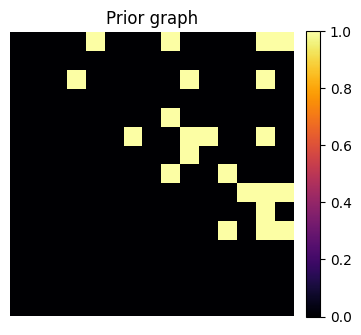

[Epoch 100/1000, patience 10] train: 13.514, val: 13.568
[Epoch 200/1000, patience  8] train: 13.505, val: 13.581
[Epoch 300/1000, patience 13] train: 13.473, val: 13.534


In [8]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

for adj_type in ["ER", "COV", "BN", "DENSE"]:
    print(f"\n\nConsidering ablation setting: {adj_type}")
    adj_mat = get_adj_mat(adj_type, X, n=X_train.shape[1])
    gen = GoggleModel(
        ds_name=dataset,
        input_dim=X_train.shape[1],
        encoder_dim=64,
        encoder_l=2,
        het_encoding=True,
        decoder_dim=64,
        decoder_l=2,
        threshold=0.1,
        het_decoder=False,
        graph_prior=torch.Tensor(adj_mat),
        prior_mask=torch.ones_like(torch.Tensor(adj_mat)),
        device="cpu",
        beta=0.1,
        seed=0,
    )
    gen.fit(X_train)
    X_synth = gen.sample(X_test)

    X_synth_loader = GenericDataLoader(
        X_synth,
        target_column="target",
    )
    X_test_loader = GenericDataLoader(
        X_test,
        target_column="target",
    )

    res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
    print(f"Quality: {res[0]:.3f}")
    print(f"Detection: {res[2]:.3f}")
    print(
        f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
    )